In [51]:
import numpy as np
from numpy import exp,sqrt as exp,sqrt
import pandas as pd
import math
import pylab
from scipy import stats
import matplotlib.pyplot as plt
import mibian
import hurst

from scipy.stats import norm
from scipy.optimize import minimize_scalar
import datetime as dt
import numpy as np
from itertools import compress

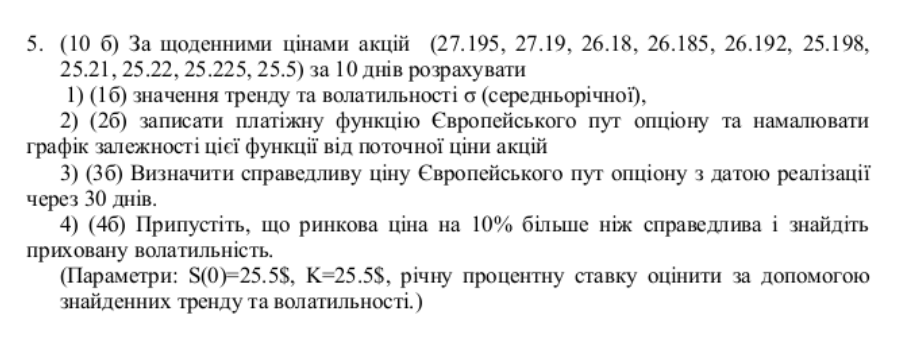

In [12]:
data=pd.DataFrame([27.195,27.19,26.18,26.185,26.192,25.198,25.21,25.22,25.225,25.5])
x=np.log(data/data.shift(1))[1:]
x

0
1 -0.000184
2 -0.037853
3  0.000191
4  0.000267
5 -0.038689
6  0.000476
7  0.000397
8  0.000198
9  0.010843

In [13]:
data.describe()

0
count  10.000000
mean   25.929500
std     0.790516
min    25.198000
25%    25.221250
50%    25.840000
75%    26.190250
max    27.195000

<AxesSubplot:>

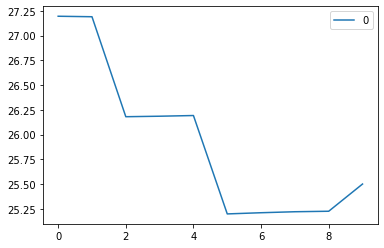

In [14]:
data.plot()

In [16]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [26]:
hurst_exp = get_hurst_exponent(data.values, 5)
print(f"Hurst exponent: {hurst_exp:.4f}")

Hurst exponent: 0.2596


<AxesSubplot:>

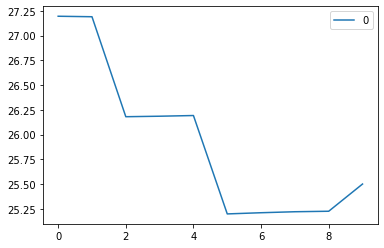

In [35]:
data.plot()

In [40]:
dt=1/252
mu=x.mean()
s=np.var(x)
sigma=s/dt

In [41]:
mu

0   -0.007151
dtype: float64

In [42]:
sigma

0    0.072456
dtype: float64

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

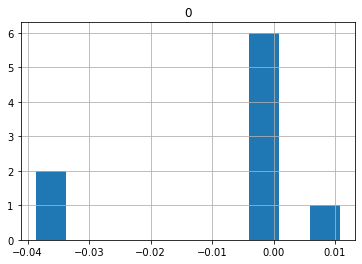

In [32]:
x.hist()

In [11]:
stats.kstest(x, 'norm')

KstestResult(statistic=0.468141316124727, pvalue=5.959268582207219e-51)

In [12]:
stats.shapiro(x)

ShapiroResult(statistic=0.9773597717285156, pvalue=0.0004919441998936236)

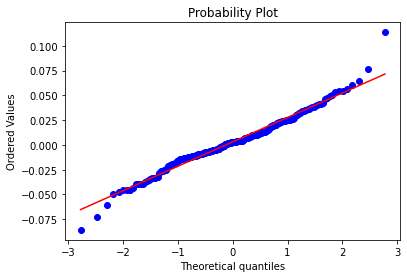

In [13]:
stats.probplot(x,dist='norm',plot=pylab)
plt.show()

In [43]:
r=mu+sigma*sigma/2
r

0   -0.004526
dtype: float64

In [27]:
def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r*T)* stats.norm.cdf(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*stats.norm.cdf(-d2) - S*stats.norm.cdf(-d1)

In [16]:
S=float(data['Close'].tail(1))
S

294.589996

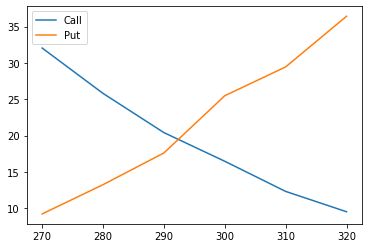

In [44]:
call_theor=[(270, 32.05),
 (280, 25.80),
 (290, 20.40),
 (300, 16.45),
 (310, 12.30),
  (320,9.5)]
put_theor=[(270, 9.20),
 (280, 13.23),
 (290, 17.60),
 (300, 25.48),
 (310, 29.45),
 (320,36.43)]
plt.plot(*zip(*call_theor),label='Call')
plt.plot(*zip(*put_theor),label='Put')
plt.legend()
plt.show()

In [18]:
call_list=[]
put_list=[]

### 23 Dec

In [49]:
put_list=[]
for i in [27.195,27.19,26.18,26.185,26.192,25.198,25.21,25.22,25.225,25.5]:
    
    put_list.append((i,BS_PUT(i,25.5,30/252 ,r,sigma)))

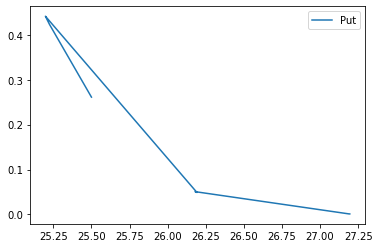

In [50]:
#plt.plot(*zip(*call_list),label='Call')
plt.plot(*zip(*put_list),label='Put')
plt.legend()
plt.show()

In [21]:
def vega(S,K,T,r,sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * stats.norm.pdf(d1) * np.sqrt(T)

In [22]:
def find_vol(target_value, S, K, T, r, *args):
    MAX_ITERATIONS = 200
    PRECISION = 1.0e-5
    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = BS_CALL(S, K, T, r, sigma)
        vega1 = vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega1 # f(x) / f'(x)
    return sigma # value wasn't found, return best guess so far

In [23]:
plot_vol=[]

V_market = BS_CALL(S,280,31/252 ,r,sigma)
implied_vol = find_vol(V_market, S,280,31/252 ,r)
plot_vol.append(implied_vol-0.1544)
print('K=280: ')
print ('Implied vol: %.10f%%' % (implied_vol * 100))
print ('Market price = %.10f' % V_market)
print ('Model price = %.10f' % BS_CALL(S,280,31/252 ,r,implied_vol))

V_market = BS_CALL(S,290,31/252 ,r,sigma)
implied_vol = find_vol(V_market, S,290,31/252 ,r)
plot_vol.append(implied_vol-0.1544)
print('K=290: ')
print ('Implied vol: %.10f%%' % (implied_vol * 100))
print ('Market price = %.10f' % V_market)
print ('Model price = %.10f' % BS_CALL(S,290,31/252 ,r,implied_vol))

V_market = BS_CALL(S,300,31/252 ,r,sigma)
implied_vol = find_vol(V_market, S,300,31/252 ,r)
plot_vol.append(implied_vol-0.1544)
print('K=300: ')
print ('Implied vol: %.10f%%' % (implied_vol * 100))
print ('Market price = %.10f' % V_market)
print ('Model price = %.10f' % BS_CALL(S,300,31/252 ,r,implied_vol))

V_market = BS_CALL(S,310,31/252 ,r,sigma)
implied_vol = find_vol(V_market, S,310,31/252 ,r)
plot_vol.append(implied_vol-0.1544)
print('K=310: ')
print ('Implied vol: %.10f%%' % (implied_vol * 100))
print ('Market price = %.10f' % V_market)
print ('Model price = %.10f' % BS_CALL(S,310,31/252 ,r,implied_vol))

V_market = BS_CALL(S,320,31/252 ,r,sigma)
implied_vol = find_vol(V_market, S,320,31/252 ,r)
plot_vol.append(implied_vol-0.1544)
print('K=320: ')
print ('Implied vol: %.10f%%' % (implied_vol * 100))
print ('Market price = %.10f' % V_market)
print ('Model price = %.10f' % BS_CALL(S,320,31/252 ,r,implied_vol))

K=280: 
Implied vol: 15.4470439197%
Market price = 16.4744431264
Model price = 16.4744431357
K=290: 
Implied vol: 15.4470438825%
Market price = 9.2029525625
Model price = 9.2029525626
K=300: 
Implied vol: 15.4470438823%
Market price = 4.2814950169
Model price = 4.2814950170
K=310: 
Implied vol: 15.4470438885%
Market price = 1.6217349532
Model price = 1.6217349550
K=320: 
Implied vol: 15.4470439130%
Market price = 0.4948486735
Model price = 0.4948486778


In [24]:
sigma

0.15447043882206632

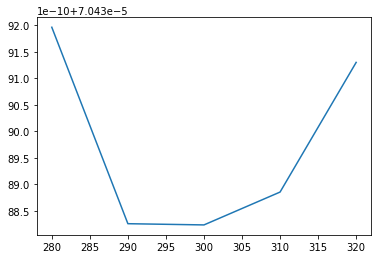

In [25]:
strike_price=[280,290,300,310,320]
plt.plot(strike_price,plot_vol)

In [48]:
c = mibian.BS([25.5, 25.5, r, 30], callPrice=28.05)
print(c.impliedVolatility)

500.0


In [45]:
x=[]
y_call=[]
y_put=[]
for i in range(len(call_theor)):
    x.append(call_theor[i][0])
    y_call.append(mibian.BS([S, call_theor[i][0], r, 31], callPrice=call_theor[i][1]).impliedVolatility)
    y_put.append((mibian.BS([S, put_theor[i][0], r, 31], putPrice=put_theor[i][1])).impliedVolatility)

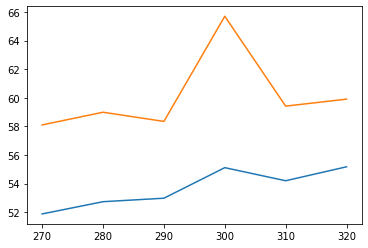

In [46]:
plt.plot(x,y_call)
plt.plot(x,y_put)

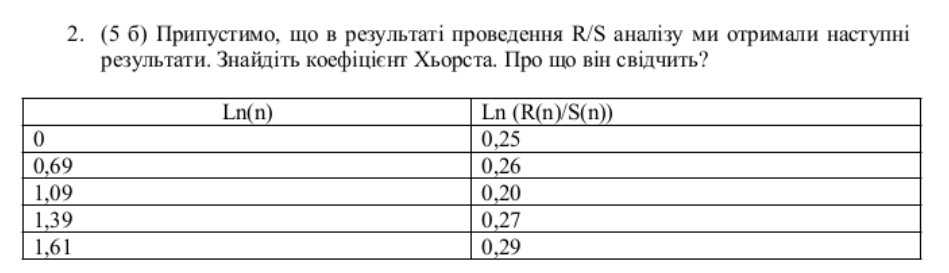

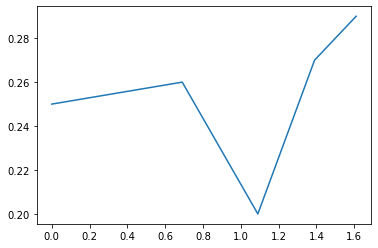

In [57]:
x=[0,0.69,1.09,1.39,1.61]
y=[0.25,0.26,0.2,0.27,0.29]
plt.plot(x,y)

In [54]:
s, i = np.polyfit(x, y, 1)

In [55]:
s

0.015740832262528336

In [56]:
i

0.2389517643570229

In [58]:
degree = np.math.atan2(y[-1] - y[0], x[-1] - x[0])

In [59]:
degree

0.02483961050408887